In [2]:
#Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn as sk
from sklearn.preprocessing import OneHotEncoder,LabelBinarizer,LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,train_test_split,StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,mean_absolute_error,explained_variance_score,confusion_matrix,make_scorer

#### Pre-processing
Variables to be processed: \
1.To splice blood pressure data to Systolic and Diastolic pressure \
2.OneHotEncode Diet Data \
3.OneHotEncode Country Data 


In [4]:
##Definitions

from sklearn.inspection import permutation_importance


def plot_permutation_importance(clf, X, y, ax):
    #conduct permutation feature importance 
    result = permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=-1)
    perm_sorted_idx = result.importances_mean.argsort()

    ax.boxplot(
        result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X.columns[perm_sorted_idx],
    )
    ax.axvline(x=0, color="k", linestyle="--")
    return ax

#Credits of definition:https://scikit-learn.org/stable/modules/permutation_importance.html
###Splice blood pressure data
def blood_p_splice(data):
    #convert data to string
    data=data.astype({'Blood Pressure': 'str'})
    #splice into two columns on delimiter "\"
    data[['Systolic_P', 'Diastolic_P']] = data['Blood Pressure'].str.split(pat="/",expand=True)
    #convert Systolic_P and Diastolic_P to int
    data=data.astype({'Systolic_P': 'int','Diastolic_P': 'int'})
    return data


###Preprocess data
def data_process(data):
    #Splice blood pressure data
    data=blood_p_splice(data)
    #onehotencode Country
    data=pd.get_dummies(data,columns=['Country'],drop_first=True,dtype=int)
    #onehotencode Diet
    data=pd.get_dummies(data,columns=['Diet'],drop_first=True,dtype=int)
    #Turn Gender to binary variable
    le = LabelEncoder()
    data['Sex_binary'] = le.fit_transform(data['Sex'])
    #drop continent and hemisphere and Blood Pressure,Sex
    data.drop(columns=['Patient ID','Continent','Hemisphere','Blood Pressure','Sex'],inplace=True)
    return data


#Train test split with stratified sampling
def ttsplit(X,y):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
    
    for i, (train_index, test_index) in enumerate(sss.split(X,y)):
        print(f"Fold {i}:")
    #create train dataset
    X_train=np.take(X, train_index, axis=0).reset_index()
    y_train=np.take(y, train_index, axis=0).reset_index()
    #create test dataset
    X_test=np.take(X, test_index, axis=0).reset_index()
    y_test=np.take(y, test_index, axis=0).reset_index()
    #return train test split
    return X_train,y_train,X_test,y_test

In [5]:
#Import train
Data=pd.read_csv("heart-attack-risk-analysis/train.csv")
#Import test
New_data=pd.read_csv("heart-attack-risk-analysis/test.csv")

In [9]:
#Process train and test dataset

#PreProcess train 
train=data_process(Data)
#keep only specific columns (customizable)
train=train[['Age','Heart Attack Risk','Cholesterol', 'Heart Rate', 'Diabetes', 'Family History','Smoking', 'Obesity', 'Alcohol Consumption', 'Exercise Hours Per Week','Previous Heart Problems', 'Medication Use', 'Stress Level','Sedentary Hours Per Day','Systolic_P','Diastolic_P','Sex_binary']]


#PreProcess test
test=data_process(New_data)
test=test[['Age','Cholesterol', 'Heart Rate', 'Diabetes', 'Family History','Smoking', 'Obesity', 'Alcohol Consumption', 'Exercise Hours Per Week','Previous Heart Problems', 'Medication Use', 'Stress Level','Sedentary Hours Per Day','Systolic_P','Diastolic_P','Sex_binary']]

In [43]:
X_train,y_train,X_test,y_test=ttsplit(train.drop(columns=['Heart Attack Risk'],axis=1), train['Heart Attack Risk'])

Fold 0:


In [45]:
#X_train,X_test,y_train,y_test=train_test_split(train.drop(columns=['Heart Attack Risk'],axis=1), train['Heart Attack Risk'],test_size=0.25,random_state=42)

In [ ]:
from sklearn.metrics import get_scorer
from sklearn.metrics import get_scorer_names
from sklearn.metrics import precision_score,recall_score,accuracy_score,fbeta_score
## Create a decision tree model

#create 4 evenly spaced integers from 1-10
lin_space=np.linspace(2, 10, 5)
lin_space=[int(x) for x in lin_space]

#create 10 evenly spaced integers
lin_space_min_sample=np.linspace(2, 100, 20)
lin_space_min_sample=[int(x) for x in lin_space]

#determine parameters of decision tree
params=[{'min_samples_leaf': lin_space_min_sample,
         'criterion': ['entropy', 'log_loss', 'gini'],
         'max_depth':lin_space}]

DTM_GS = GridSearchCV(DecisionTreeClassifier(),
                      param_grid=params,
                      scoring={'recall': make_scorer(recall_score)},refit='recall',
                      cv=5,n_jobs=-1)

DTM_GS.fit(X_train,y_train)
DTM_GS.best_params_
DTM_GS.score(X_train, y_train)  
DTM_GS_best_estimator = DTM_GS.best_estimator_

print(f"Best estimator has {DTM_GS.best_params_['min_samples_leaf']} minimum samples per leaf,uses {DTM_GS.best_params_['criterion']} criterion and Max depth of {DTM_GS.best_params_['max_depth']} splits")
y_pred = DTM_GS_best_estimator.predict(X_test)
pred_proba = DTM_GS_best_estimator.predict_proba(X_test)
print("recall: ",recall_score(y_test, y_pred))

In [ ]:
class_labels = DTM_GS_best_estimator.classes_
positive_label_idx = np.where(class_labels == 0)[0][0]
print(positive_label_idx)

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test,pred_proba[:,1])
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='Decision_Tree')
display.plot()
plt.show()

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred),annot=True)

In [ ]:
fig, ax = plt.subplots(figsize=(7, 6))
#Conduct and plot permutation feature importance
plot_permutation_importance(DTM_GS_best_estimator, X_train, y_train, ax)
ax.set_title("Permutation Importances on multicollinear features\n(train set)")
ax.set_xlabel("Decrease in accuracy score")
_ = ax.figure.tight_layout()

In [ ]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))
#conduct spearman rank order correlation 
corr = spearmanr(X_train).correlation
# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X_train.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

#ax1.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
#ax1.set_xticks(dendro_idx)
#ax1.set_yticks(dendro_idx)
#ax1.set_xticklabels(dendro["ivl"], rotation="vertical")
#ax1.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()
#Will manually pick 1 variable from clusters to minimise multicollinearity

In [199]:

#keep only specific columns (customizable)
train_2=train[['Heart Attack Risk','Cholesterol','Systolic_P','Diabetes','Diastolic_P','Sedentary Hours Per Day']]
#Create a train and test set
X_train2, X_test2, y_train2, y_test2 = train_test_split(train_2.drop(columns=['Heart Attack Risk'],axis=1), train_2['Heart Attack Risk'], test_size=0.25, random_state=100)



In [200]:
from sklearn.metrics import get_scorer
from sklearn.metrics import get_scorer_names
from sklearn.metrics import precision_score,recall_score,accuracy_score
## Create a decision tree model

#create 4 evenly spaced integers from 1-10
lin_space=np.linspace(2, 10, 5)
lin_space=[int(x) for x in lin_space]

#create 10 evenly spaced integers
lin_space_min_sample=np.linspace(2, 100, 20)
lin_space_min_sample=[int(x) for x in lin_space]

#determine parameters of decision tree
params=[{'min_samples_leaf': lin_space_min_sample,
         'criterion': ['entropy', 'log_loss', 'gini'],
         'max_depth':lin_space}]

DTM_GS2 = GridSearchCV(DecisionTreeClassifier(),
                      param_grid=params,
                      scoring={'fbeta': make_scorer(fbeta_score, beta=1.85)},refit='fbeta',
                      cv=5,n_jobs=-1)

DTM_GS2.fit(X_train2, y_train2)
DTM_GS2.best_params_
DTM_GS2.score(X_train2, y_train2)  
DTM_GS2_best_estimator = DTM_GS2.best_estimator_

print(f"Best estimator has {DTM_GS.best_params_['min_samples_leaf']} minimum samples per leaf,uses {DTM_GS.best_params_['criterion']} criterion and Max depth of {DTM_GS.best_params_['max_depth']} splits")
y_pred2 = DTM_GS2_best_estimator.predict(X_test2)
pred_proba2 = DTM_GS2_best_estimator.predict_proba(X_test2)
print("accuracy: ",accuracy_score(y_test, y_pred))

Best estimator has 6 minimum samples per leaf,uses gini criterion and Max depth of 10 splits
accuracy:  0.5803138373751783


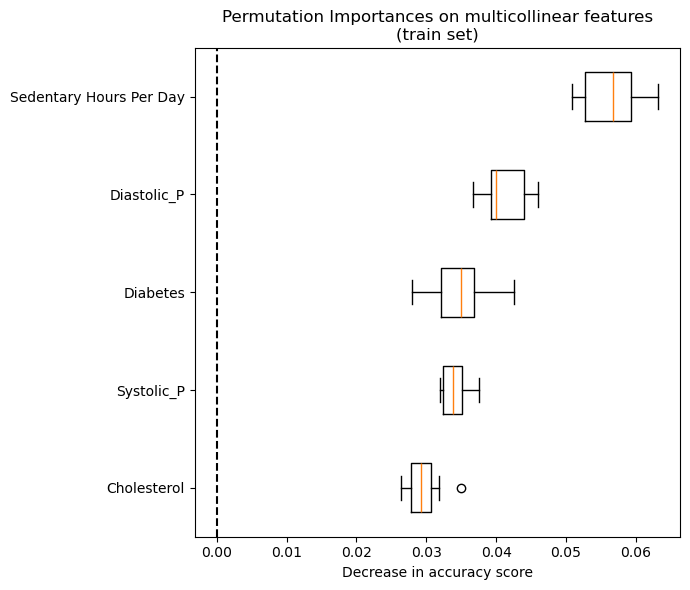

In [201]:
fig, ax = plt.subplots(figsize=(7, 6))
#Conduct and plot permutation feature importance
plot_permutation_importance(DTM_GS2_best_estimator, X_train2, y_train2, ax)
ax.set_title("Permutation Importances on multicollinear features\n(train set)")
ax.set_xlabel("Decrease in accuracy score")
_ = ax.figure.tight_layout()

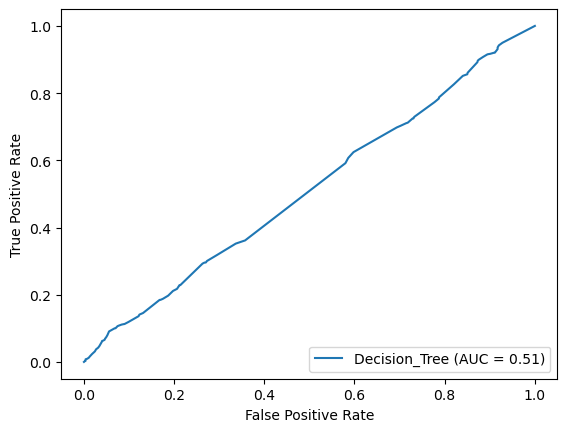

In [202]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test2,pred_proba2[:,1])
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='Decision_Tree')
display.plot()
plt.show()

<Axes: >

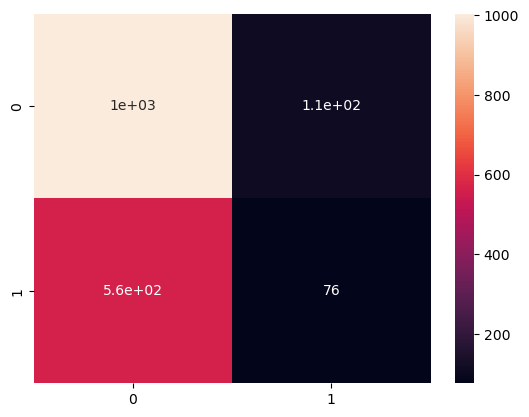

In [203]:
sns.heatmap(confusion_matrix(y_test2, y_pred2),annot=True)